<a href="https://colab.research.google.com/github/Andy-jorg/Image_dataset_for_Pretest/blob/main/Pr%C3%A6test_modellering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First we install ktrain, load some packages and clone our repository with the necessary data

In [ ]:
!pip install ktrain

In [2]:
%matplotlib inline
import os
import ktrain
from ktrain import vision as vis
import pandas as pd
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [16]:
!git clone https://github.com/Andy-jorg/Image_dataset_for_Pretest

# Run this below if you want to remove it to reclone
#!rm -rf "/content/Image_dataset_for_Pretest"

Cloning into 'Image_dataset_for_Pretest'...
remote: Enumerating objects: 590, done.
remote: Counting objects: 100% (344/344), done.
remote: Compressing objects: 100% (318/318), done.
remote: Total 590 (delta 31), reused 334 (delta 23), pack-reused 246
Receiving objects: 100% (590/590), 452.88 MiB | 8.73 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Updating files: 100% (550/550), done.


Let's see if the cloning works and we can see some pictures

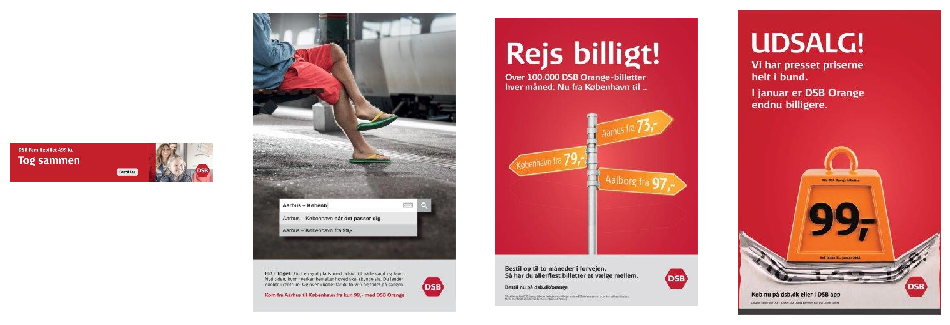

In [10]:
vis.show_random_images('/content/Image_dataset_for_Pretest/Images_for_model')

# Prepare and preprocess the data

Now we'll use ktrain to set up the data

First we start by creating a function that partitions our images into train and validation set and where we know information about our scores

In [17]:
# Alter the code below to have the correct images folder (directory) and train and val fpath, depending on whether it is means, sample, with or without extra train set etc.

def images_from_csv():
    train_fpath = '/content/Image_dataset_for_Pretest/csv_files/images_train_means.csv'
    val_fpath = '/content/Image_dataset_for_Pretest/csv_files/images_val_means.csv'
    trn, val, preproc = vis.images_from_csv(
                          train_fpath,
                          'image',
                          directory='/content/Image_dataset_for_Pretest/Images_for_model', # don't use "Images_full_size", it is very large
                          is_regression = True,
                          val_filepath = val_fpath,
                          target_size = (224, 224),
                          label_columns = 'liking',
                          data_aug=vis.get_data_aug(horizontal_flip=True))
    return (trn, val, preproc)

Put into train and val data set

In [18]:
(train_data, val_data, preproc) = images_from_csv()

['liking']
     liking
0  3.292796
1  3.550538
2  3.326425
3  2.677903
4  3.292796
['liking']
     liking
0  3.412055
1  3.267089
2  3.460744
3  3.580145
4  3.616890
Found 243 images belonging to 1 classes.


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:727: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  warnings.warn(


Found 173 validated image filenames.
Found 44 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


# Create model and wrap in Learner object

See available models

In [ ]:
vis.print_image_regression_models()

pretrained_resnet50: 50-layer Residual Network (pretrained on ImageNet)
resnet50: 50-layer Resididual Network (randomly initialized) [https://arxiv.org/abs/1512.03385]
pretrained_mobilenet: MobileNet Neural Network (pretrained on ImageNet)
mobilenet: MobileNet Neural Network (randomly initialized) [https://arxiv.org/abs/1704.04861]
pretrained_mobilenetv3: MobileNetV3-Small Neural Network (pretrained on ImageNet)
mobilenetv3: MobileNetV3-Small Neural Network (randomly initialized) [https://arxiv.org/abs/1905.02244]
pretrained_inception: Inception Version 3  (pretrained on ImageNet)
inception: Inception Version 3 (randomly initialized) [http://arxiv.org/abs/1512.00567]
pretrained_efficientnetb1: EfficientNet-B1 Neural Network (pretrained on ImageNet)
efficientnetb1: EfficientNet-B1 Neural Network (pretrained on ImageNet) [https://arxiv.org/abs/1905.11946]
pretrained_efficientnetb7: EfficientNet-B7 Neural Network (pretrained on ImageNet)
efficientnetb7: EfficientNet-B7 Neural Network (pre

Now we chose the model - let's try with ResNet50
By default, the model freezes all layers except the final randomly-initialized dense layer.

In [20]:
model = vis.image_regression_model('pretrained_resnet50',
                                   train_data = train_data,
                                   val_data = val_data)

The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
Is Regression? True
pretrained_resnet50 model created.


Wrap model and data in Learner object Remember to adjust the batch size

In [21]:
# We are doing batch size 64 for data on respondent level and 16 or 32 for means
learner = ktrain.get_learner(model = model,
                             train_data = train_data,
                             val_data = val_data,
                             batch_size = 16)

learner

# Estimate the optimal learning rate

To find optimal learning rate run the code below. However, it is very slow.

In [22]:
learner.lr_find(max_epochs=2)

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/2
10/10 [==============================] - 12s 278ms/step - loss: 20.0909 - mae: 3.6104
Epoch 2/2
10/10 [==============================] - 1s 110ms/step - loss: 2312.1890 - mae: 29.9188


/usr/local/lib/python3.10/dist-packages/ktrain/lroptimize/lrfinder.py:267: UserWarning: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.
  warnings.warn(str(e))




done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


In [ ]:
learner.lr_plot()

# Training

We will begin by training the model for 7 epochs using a 1cycle (https://arxiv.org/abs/1803.09820) learning rate policy.

In [24]:
learner.fit_onecycle(1e-4, 7)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/7
11/11 [==============================] - 13s 904ms/step - loss: 15.2260 - mae: 3.1781 - val_loss: 5.5274 - val_mae: 1.8990
Epoch 2/7
11/11 [==============================] - 3s 288ms/step - loss: 10.6209 - mae: 2.5623 - val_loss: 6.5310 - val_mae: 1.9592
Epoch 3/7
11/11 [==============================] - 4s 404ms/step - loss: 13.2679 - mae: 2.8909 - val_loss: 4.2104 - val_mae: 1.6922
Epoch 4/7
11/11 [==============================] - 3s 285ms/step - loss: 9.7454 - mae: 2.4401 - val_loss: 4.2739 - val_mae: 1.5763
Epoch 5/7
11/11 [==============================] - 6s 582ms/step - loss: 10.3097 - mae: 2.5996 - val_loss: 5.6894 - val_mae: 1.9025
Epoch 6/7
11/11 [==============================] - 8s 727ms/step - loss: 10.2633 - mae: 2.4518 - val_loss: 3.9694 - val_mae: 1.5599
Epoch 7/7
11/11 [==============================] - 3s 274ms/step - loss: 11.9883 - mae: 2.7645 - val_loss: 3.8373 - val_mae: 1.5296


Run the code below to save the learning. Remember to update the path

In [32]:
ktrain.get_predictor(learner.model, preproc).save('/content/gdrive/MyDrive/Colab/my_predictor_means') # Remember to update path

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Try to load model and keep training

In [27]:
model = ktrain.load_predictor('/content/gdrive/MyDrive/Colab/my_predictor_means').model

# re-instantiate Learner and continue training
learner = ktrain.get_learner(model, train_data = train_data, val_data = val_data)


Now we will freze some layers and train for another two epochs on the remaining unfreezed layers. We will freeze the first 20 layers.

In [30]:
# 20 works good with a respondent-level data. Not good with means. Trying to unfreeze 10 with means 10 yields roughly the same. Try just 3 layers. 3 layers followed by 1 worked the best

learner.freeze(1)

learner.fit_onecycle(1e-4, 4)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/4
6/6 [==============================] - 10s 773ms/step - loss: 9.3003 - mae: 2.3923 - val_loss: 3.1843 - val_mae: 1.4227
Epoch 2/4
6/6 [==============================] - 5s 970ms/step - loss: 9.4227 - mae: 2.4395 - val_loss: 4.4951 - val_mae: 1.7295
Epoch 3/4
6/6 [==============================] - 4s 559ms/step - loss: 10.4093 - mae: 2.6134 - val_loss: 3.6416 - val_mae: 1.5221
Epoch 4/4
6/6 [==============================] - 5s 869ms/step - loss: 9.1946 - mae: 2.3549 - val_loss: 2.1761 - val_mae: 1.1487


# Prediction

In [31]:
predictor = ktrain.get_predictor(learner.model, preproc)

Now we try to predict based on filenames. First we import the necessary datafiles

In [ ]:
#DATADIR = "/content/Image_dataset_for_Pretest/Images_5"

DATADIR = "/content/Image_dataset_for_Pretest/Test images"

# Create a list of image file names
image_files = [f for f in os.listdir(DATADIR) if f.endswith(('.jpg', '.jpeg', '.png'))]



In [ ]:
# Create a DataFrame to store predictions
predictions_df = pd.DataFrame(columns=['Image', 'Prediction'])


In [ ]:
# Loop through each image, make predictions, and store results in the DataFrame
for image_file in image_files:
    image_path = os.path.join(DATADIR, image_file)

   # Make prediction using the predictor
    prediction = predictor.predict_filename(image_path)

    # Append results to DataFrame
    predictions_df = predictions_df.append({'Image': image_file, 'Prediction': prediction}, ignore_index=True)


Now we save the file as a .csv file to the drive

In [ ]:
# Save the DataFrame as a CSV or Excel file
csv_filename = "/content/gdrive/MyDrive/Colab/predictions_means_images_15012024.csv"
predictions_df.to_csv(csv_filename, index=False)